In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [44]:
df = pd.read_csv("flights_sample_10k.csv")

In [46]:
print(df.info())             # Data types, missing values
print(df.describe())         # Summary stats
print(df.head())             # Preview first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FL_DATE                  10000 non-null  object 
 1   AIRLINE                  10000 non-null  object 
 2   AIRLINE_DOT              10000 non-null  object 
 3   AIRLINE_CODE             10000 non-null  object 
 4   DOT_CODE                 10000 non-null  int64  
 5   FL_NUMBER                10000 non-null  int64  
 6   ORIGIN                   10000 non-null  object 
 7   ORIGIN_CITY              10000 non-null  object 
 8   DEST                     10000 non-null  object 
 9   DEST_CITY                10000 non-null  object 
 10  CRS_DEP_TIME             10000 non-null  int64  
 11  DEP_TIME                 9762 non-null   float64
 12  DEP_DELAY                9762 non-null   float64
 13  TAXI_OUT                 9759 non-null   float64
 14  WHEELS_OFF             

In [48]:
# Convert flight date to datetime
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

In [50]:
missing = df.isnull().sum().sort_values(ascending=False)

In [52]:
# Drop rows with missing key delay values
df_cleaned = df.dropna(subset=["DEP_DELAY", "ARR_DELAY"])

In [54]:
# Fill missing categorical field
df_cleaned["CANCELLATION_CODE"].fillna("None", inplace=True)

C:\Users\malak\AppData\Local\Temp\ipykernel_32236\1585036905.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["CANCELLATION_CODE"].fillna("None", inplace=True)
C:\Users\malak\AppData\Local\Temp\ipykernel_32236\1585036905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["CANCELLATION_CODE"].fillna("None", inplace=Tru

In [56]:
#feature engineering
df_cleaned["DAY_OF_WEEK"] = df_cleaned["FL_DATE"].dt.day_name()
df_cleaned["ARR_DELAY_SEVERITY"] = pd.cut(
    df_cleaned["ARR_DELAY"],
    bins=[-1000, 0, 15, 60, 1000],
    labels=["Early/On-Time", "Slightly Delayed", "Moderately Delayed", "Heavily Delayed"]
)

C:\Users\malak\AppData\Local\Temp\ipykernel_32236\1572454253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["DAY_OF_WEEK"] = df_cleaned["FL_DATE"].dt.day_name()
C:\Users\malak\AppData\Local\Temp\ipykernel_32236\1572454253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["ARR_DELAY_SEVERITY"] = pd.cut(


In [58]:
# Export cleaned data
df_cleaned.to_csv("cleaned_flights.csv", index=False)

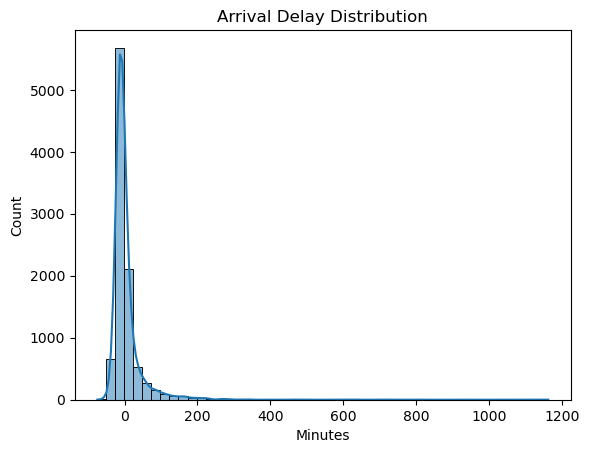

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Delay distribution
sns.histplot(df_cleaned["ARR_DELAY"], bins=50, kde=True)
plt.title("Arrival Delay Distribution")
plt.xlabel("Minutes")
plt.show()

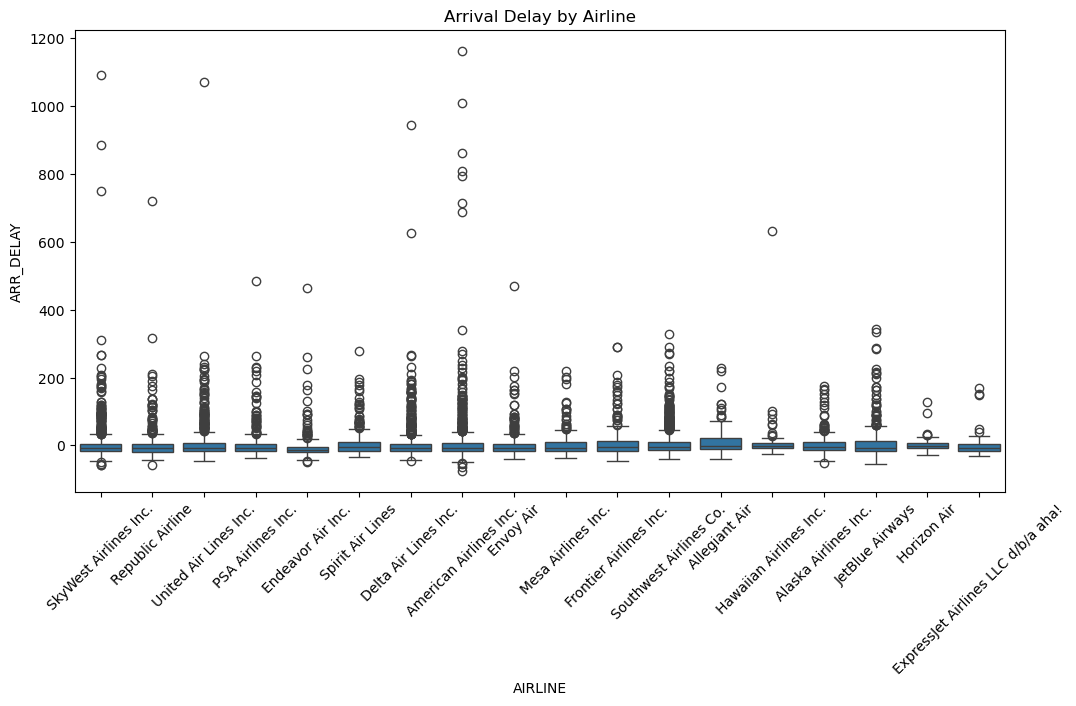

In [62]:
# Boxplot of delays by airline
plt.figure(figsize=(12,6))
sns.boxplot(x="AIRLINE", y="ARR_DELAY", data=df_cleaned)
plt.xticks(rotation=45)
plt.title("Arrival Delay by Airline")
plt.show()

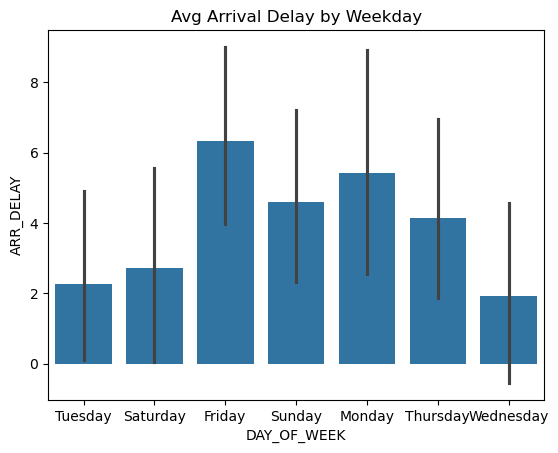

In [64]:
# Average delay by day of week
sns.barplot(x="DAY_OF_WEEK", y="ARR_DELAY", data=df_cleaned)
plt.title("Avg Arrival Delay by Weekday")
plt.show()

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Binary classification: Was the flight delayed?
df_cleaned["DELAYED"] = (df_cleaned["ARR_DELAY"] > 15).astype(int)

# Simple features
features = ["DISTANCE", "DEP_DELAY", "TAXI_OUT"]
X = df_cleaned[features].dropna()
y = df_cleaned.loc[X.index, "DELAYED"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestClassifier()
model.fit(X_train, y_train)
print("Accuracy:", model.score(X_test, y_test))

C:\Users\malak\AppData\Local\Temp\ipykernel_32236\554386900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["DELAYED"] = (df_cleaned["ARR_DELAY"] > 15).astype(int)


Accuracy: 0.9548254620123203


In [157]:
import sqlite3
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("cleaned_flights.csv")

# Connect to SQLite (or create database file)
conn = sqlite3.connect("flights.db")

# Write the DataFrame to a new table
df.to_sql("flights", conn, if_exists="replace", index=False)

# Optional: Verify table creation
print(pd.read_sql("SELECT * FROM flights LIMIT 5", conn))

conn.close()

      FL_DATE                AIRLINE                AIRLINE_DOT AIRLINE_CODE  \
0  2022-07-19  SkyWest Airlines Inc.  SkyWest Airlines Inc.: OO           OO   
1  2022-09-13       Republic Airline       Republic Airline: YX           YX   
2  2022-07-09  SkyWest Airlines Inc.  SkyWest Airlines Inc.: OO           OO   
3  2021-03-19  United Air Lines Inc.  United Air Lines Inc.: UA           UA   
4  2020-01-03  United Air Lines Inc.  United Air Lines Inc.: UA           UA   

   DOT_CODE  FL_NUMBER ORIGIN     ORIGIN_CITY DEST          DEST_CITY  ...  \
0     20304       3371    SAN   San Diego, CA  SFO  San Francisco, CA  ...   
1     20452       3552    CMH    Columbus, OH  ORD        Chicago, IL  ...   
2     20304       4660    CVG  Cincinnati, OH  ORD        Chicago, IL  ...   
3     19977        325    DEN      Denver, CO  MCI    Kansas City, MO  ...   
4     19977       1561    IAH     Houston, TX  SFO  San Francisco, CA  ...   

   ELAPSED_TIME  AIR_TIME  DISTANCE  DELAY_DUE_CAR

In [159]:
conn = sqlite3.connect("flights.db")

#all queries and exports here
df = pd.read_sql("SELECT * FROM flights LIMIT 10", conn)
df.to_csv("some_output.csv", index=False)

# Close AFTER you're done
conn.close()


In [161]:
# Connect to your existing flights.db
conn = sqlite3.connect("flights.db")

# Step 1: Create the airlines table
conn.execute("""
CREATE TABLE IF NOT EXISTS airlines (
    airline_code TEXT PRIMARY KEY,
    airline_name TEXT
)
""")

# Step 2: Insert data into airlines table
airlines = [
    ("WN", "Southwest Airlines"),
    ("AA", "American Airlines"),
    ("DL", "Delta Air Lines"),
    ("UA", "United Airlines"),
    ("OO", "SkyWest Airlines")
]

# Use executemany to insert multiple rows
conn.executemany("INSERT OR REPLACE INTO airlines VALUES (?, ?)", airlines)

# Step 3: Commit changes and optionally close
conn.commit()
conn.close()
